# RoBERTa-based Manipulation Detection (Binary Classification) with PEFT/LORA
## Wights un-capped and un-normalized on "Manipulative" column
This notebook uses `roberta-base` to classify dialogue as manipulative or not using the MentalManip dataset. Weights are added to a custom crossentrpoy loss function to balance the label representation:
- Minority class errors more costly
- Majority class errors less costly

Weights in this 'V1' case are calculated to un-boundedly match the label skewness

In [1]:
!pip install -q datasets
!pip install -q evaluate
## transformers upgrade
!pip install -q --upgrade transformers

## Datasets need upgrading to work
!pip install -q --upgrade datasets

## LoRA addon
!pip install -q peft accelerate

## Seaborn for plotting the label distribution
!pip install -q seaborn

## Early stopping
from transformers import EarlyStoppingCallback


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [2]:
import numpy as np
import pandas as pd
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import classification_report

## PLotting
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# Load the MentalManip dataset (binary classification)
# Load dataset
dataset = load_dataset("audreyeleven/MentalManip", name="mentalmanip_maj")

print(dataset)


README.md: 0.00B [00:00, ?B/s]

Some datasets params were ignored: ['license']. Make sure to use only valid params for the dataset builder and to have a up-to-date version of the `datasets` library.


mentalmanip_maj.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/4000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'manipulative', 'technique', 'vulnerability'],
        num_rows: 4000
    })
})


In [4]:
# Ensure the 'manipulative' column is class-labeled
# The class_encode_column method converts the feature type of the existing column
# to ClassLabel in-place. It does NOT create a new column named 'labels'.
dataset = dataset.class_encode_column("manipulative")

print("Dataset after class_encode_column:")
print(dataset)
print("\nFeatures of the training split:")
print(dataset['train'].features)


# If you specifically wanted a column named 'labels', you could rename the column like this:
# dataset = dataset.rename_column("manipulative", "labels")
# print("\nDataset after renaming 'manipulative' to 'labels':")
# print(dataset)

# Apply to all splits
#dataset = dataset.map(lambda x: {"labels": label_for_binary(x)})
#label_list = [0, 1]
#id2label = {0: "non-target", 1: target_column}
#label2id = {"non-target": 0, target_column: 1}

#print("Binary labels applied for:", target_column)
#print(dataset)
#print(dataset['train']['labels'])

Stringifying the column:   0%|          | 0/4000 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/4000 [00:00<?, ? examples/s]

Dataset after class_encode_column:
DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'manipulative', 'technique', 'vulnerability'],
        num_rows: 4000
    })
})

Features of the training split:
{'id': Value('int64'), 'dialogue': Value('string'), 'manipulative': ClassLabel(names=['0', '1']), 'technique': Value('string'), 'vulnerability': Value('string')}


/tmp/ipython-input-4160574222.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y='manipulative', data=df, order=df['manipulative'].value_counts().index,  palette="viridis")


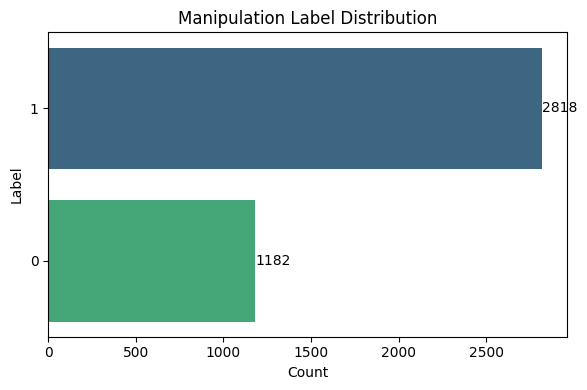

In [5]:
df = dataset["train"].to_pandas()


## PLot the label distribution
plt.figure(figsize=(6, 4))
ax = sns.countplot(y='manipulative', data=df, order=df['manipulative'].value_counts().index,  palette="viridis")
# Loop through each container of bars and add labels
for container in ax.containers:
    ax.bar_label(container)



plt.title(f"Manipulation Label Distribution")
plt.xlabel("Count")
plt.ylabel("Label")
plt.tight_layout()
plt.show()

In [6]:
model_ckpt = "roberta-base"

In [7]:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize_fn(example):
    return tokenizer(example["dialogue"], truncation=True, padding="max_length", max_length=128)

tokenized = dataset.map(tokenize_fn, batched=True)
print(tokenized)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'manipulative', 'technique', 'vulnerability', 'input_ids', 'attention_mask'],
        num_rows: 4000
    })
})


In [8]:
## Setup the PEFT addon

from peft import get_peft_model, LoraConfig, TaskType

# Define your LoRA configuration
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,           # Sequence classification
    inference_mode=False,                 # True = inference only
    r=8,                                  # Low-rank dimension
    lora_alpha=16,                        # Scaling factor
    lora_dropout=0.1,                     # Dropout in LoRA layers
    bias="none",
    target_modules=["query", "value"]     # Apply only to LoRA layers
)

from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


In [9]:

base_model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=2)

# Wrap with LoRA
model = get_peft_model(base_model, peft_config)

# Print trainable layers
#for name, module in model.named_modules():
#    if "attention" in name and any(k in name for k in ["query", "key", "value"]):
#        print(name)


# Optional: Show how many parameters are trainable
model.print_trainable_parameters()





model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 887,042 || all params: 125,534,212 || trainable%: 0.7066


In [10]:
# Freeze the first 6 encoder layers
N = 6  # Number of layers to freeze
base_model = model.roberta  # Access the base RoBERTa model inside the classifier

# Freeze the encoder layers
for i in range(N):
    for param in base_model.encoder.layer[i].parameters():
        param.requires_grad = False

# Fine-tune the remaining layers
for i in range(N, len(base_model.encoder.layer)):
    for param in base_model.encoder.layer[i].parameters():
        param.requires_grad = True

# Ensure LoRA adapter layers remain trainable
for name, param in model.named_parameters():
    if "lora" in name:
        param.requires_grad = True

# Iterate through each encoder layer and print the status of each parameter
for i, layer in enumerate(base_model.encoder.layer):
    print(f"Layer {i + 1}:")

    # Check each parameter in the layer and print if it's frozen or trainable
    for param_name, param in layer.named_parameters():
        status = "trainable" if param.requires_grad else "frozen"
        print(f"  - {param_name}: {status}")


# Show how many parameters are trainable
model.print_trainable_parameters()


Layer 1:
  - attention.self.query.base_layer.weight: frozen
  - attention.self.query.base_layer.bias: frozen
  - attention.self.query.lora_A.default.weight: trainable
  - attention.self.query.lora_B.default.weight: trainable
  - attention.self.key.weight: frozen
  - attention.self.key.bias: frozen
  - attention.self.value.base_layer.weight: frozen
  - attention.self.value.base_layer.bias: frozen
  - attention.self.value.lora_A.default.weight: trainable
  - attention.self.value.lora_B.default.weight: trainable
  - attention.output.dense.weight: frozen
  - attention.output.dense.bias: frozen
  - attention.output.LayerNorm.weight: frozen
  - attention.output.LayerNorm.bias: frozen
  - intermediate.dense.weight: frozen
  - intermediate.dense.bias: frozen
  - output.dense.weight: frozen
  - output.dense.bias: frozen
  - output.LayerNorm.weight: frozen
  - output.LayerNorm.bias: frozen
Layer 2:
  - attention.self.query.base_layer.weight: frozen
  - attention.self.query.base_layer.bias: froze

Counter({1: 2818, 0: 1182})
Class weights: tensor([3.3841, 1.4194])


/tmp/ipython-input-1058212325.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Label", y="Weight", data=df_w, palette="viridis")


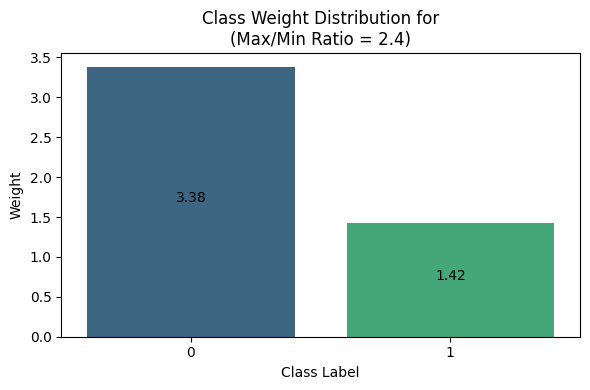

In [11]:

from collections import Counter
import torch

label_counts = Counter(dataset['train']['manipulative'])

print(label_counts)

total = sum(label_counts.values())

## Normalized capped weights
#max_ratio = 3.0
#weights = [min(total / count, max_ratio) for count in label_counts.values()]
#class_weights = torch.tensor(weights).to(model.device)

## Normalized Weigts
#weights = torch.tensor([total / label_counts[i] for i in range(len(label_counts))], dtype=torch.float)
#weights = weights / weights.sum()  # Normalize so sum = 1
#class_weights = weights.to(model.device)


weights = [total / label_counts[i] for i in range(len(label_counts))]
class_weights = torch.tensor(weights).to(model.device)
print("Class weights:", class_weights)

# Prepare DataFrame
df_w = pd.DataFrame({
    "Label": range(len(class_weights)),
    "Weight": class_weights.cpu().numpy()
})

# Calculate ratio
weight_ratio = (class_weights.max() / class_weights.min()).item()

# Plot
plt.figure(figsize=(6, 4))
ax = sns.barplot(x="Label", y="Weight", data=df_w, palette="viridis")

# Add labels on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='center', padding=3)

plt.title(f"Class Weight Distribution for\n(Max/Min Ratio = {weight_ratio:.1f})")
plt.xlabel("Class Label")
plt.ylabel("Weight")
plt.tight_layout()
plt.show()

In [12]:
# Split the dataset into training and testing sets
train_test_split = tokenized["train"].train_test_split(test_size=0.2) # Adjust the test_size as needed

# Update the tokenized dataset with the new splits
tokenized["train"] = train_test_split["train"]
tokenized["test"] = train_test_split["test"]

# Make the data work with the nomenclature
tokenized = tokenized.rename_column("manipulative", "labels")

print(tokenized)

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'labels', 'technique', 'vulnerability', 'input_ids', 'attention_mask'],
        num_rows: 3200
    })
    test: Dataset({
        features: ['id', 'dialogue', 'labels', 'technique', 'vulnerability', 'input_ids', 'attention_mask'],
        num_rows: 800
    })
})


In [13]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt,
    num_labels=2  # Binary classification
)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
## Stop epochs if overfitting
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=2,  # Stop after 2 epochs without improvement
    early_stopping_threshold=0.0
)


In [15]:
## Training args

training_args = TrainingArguments(
    metric_for_best_model='f1',  ## F1 metrics
    greater_is_better=True,
    output_dir="./bert-binary-manip",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=8,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    run_name="bert-binary-manip",
    report_to="none",
    learning_rate=1e-5,
    warmup_ratio=0.1,

)

In [16]:
## Evaluation metrics

import evaluate
import numpy as np

accuracy = evaluate.load('accuracy')
precision = evaluate.load('precision')
recall = evaluate.load('recall')
f1 = evaluate.load('f1')

def compute_metrics(p):
    predictions, labels = p
    predictions_argmax = np.argmax(predictions, axis=1)

    return {
        "accuracy": accuracy.compute(predictions=predictions_argmax, references=labels)["accuracy"],
        "precision": precision.compute(predictions=predictions_argmax, references=labels, average='weighted')["precision"],
        "recall": recall.compute(predictions=predictions_argmax, references=labels, average='weighted')["recall"],
        "f1": f1.compute(predictions=predictions_argmax, references=labels, average='weighted')["f1"],
    }

In [17]:
from transformers import Trainer
from torch.nn import CrossEntropyLoss
import torch

# Custom Trainer with class-weighted loss
class CustomWeightedLossTrainer(Trainer):
    def __init__(self, *args, class_weights, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # Move class_weights to the same device as the model
        loss_fct = CrossEntropyLoss(weight=self.class_weights.to(model.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss


trainer = CustomWeightedLossTrainer(
    class_weights=class_weights,
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["test"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[early_stopping], # Pass callbacks here, early overfit stop
)
trainer.train()

/tmp/ipython-input-1956894044.py:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomWeightedLossTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.641800,0.723052,0.691250,0.477827,0.691250,0.565057
2,0.666100,0.660880,0.500000,0.698485,0.500000,0.493249
3,0.591500,0.673708,0.681250,0.688234,0.681250,0.684367
4,0.636100,0.710778,0.685000,0.682903,0.685000,0.683913
5,0.420300,0.828334,0.687500,0.691787,0.687500,0.689492
6,0.330000,1.109023,0.710000,0.693371,0.710000,0.697415
7,0.283700,1.132218,0.686250,0.679112,0.686250,0.682208
8,0.170900,1.264279,0.700000,0.684353,0.700000,0.689089


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.

TrainOutput(global_step=1600, training_loss=0.4660520479083061, metrics={'train_runtime': 743.6338, 'train_samples_per_second': 34.426, 'train_steps_per_second': 2.152, 'total_flos': 1683910754304000.0, 'train_loss': 0.4660520479083061, 'epoch': 8.0})

In [18]:

##  Easy eval results...
##  Get the log history from the trainer state
log_history = trainer.state.log_history

# Initialize placeholders
last_train_loss = None
last_eval_loss = None

# Iterate through log history to find the last recorded train and eval loss
for log in reversed(log_history):
    if last_eval_loss is None and "eval_loss" in log:
        last_eval_loss = log["eval_loss"]
    if last_train_loss is None and "loss" in log:
        last_train_loss = log["loss"]
    if last_train_loss is not None and last_eval_loss is not None:
        break

# Calculate overfitting ratio
if last_train_loss is not None and last_eval_loss is not None:
    ratio = last_train_loss / last_eval_loss
    print(f"Training Loss: {last_train_loss:.5f}")
    print(f"Validation Loss: {last_eval_loss:.5f}")
    print(f"Overfitting Ratio: {ratio:.5f}")
    if ratio < 0.6:
        print("Overfitting detected!")
    else:
        print("No significant overfitting.")
else:
    print("Could not find both training and evaluation loss in log history.")


Training Loss: 0.17090
Validation Loss: 1.26428
Overfitting Ratio: 0.13518
Overfitting detected!


In [19]:
# Predict on test set
preds = trainer.predict(tokenized["test"])
y_pred = preds.predictions.argmax(-1)
y_true = preds.label_ids

# Detailed classification report
print(classification_report(y_true, y_pred, target_names=["non-manipulative", "manipulative"]))


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


                  precision    recall  f1-score   support

non-manipulative       0.54      0.41      0.47       247
    manipulative       0.76      0.84      0.80       553

        accuracy                           0.71       800
       macro avg       0.65      0.63      0.63       800
    weighted avg       0.69      0.71      0.70       800



In [20]:
print(train_test_split["train"])
from collections import Counter
print("Label distribution in training set:", Counter(train_test_split["train"]['manipulative']))
print("Label distribution in validation set:", Counter(train_test_split["test"]['manipulative']))


Dataset({
    features: ['id', 'dialogue', 'manipulative', 'technique', 'vulnerability', 'input_ids', 'attention_mask'],
    num_rows: 3200
})
Label distribution in training set: Counter({1: 2265, 0: 935})
Label distribution in validation set: Counter({1: 553, 0: 247})


In [21]:

preds = trainer.predict(train_test_split["test"])
import numpy as np
predicted_labels = np.argmax(preds.predictions, axis=1)
print("Predicted label distribution:", dict(Counter(predicted_labels)))


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Predicted label distribution: {np.int64(0): 187, np.int64(1): 613}


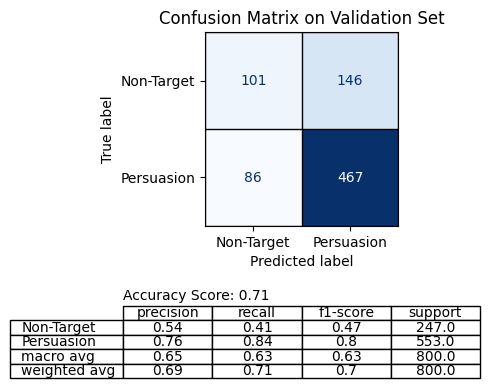

In [22]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Get predictions
predictions = trainer.predict(tokenized["test"])
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Target", "Persuasion"])

# Create classification report DataFrame
report_dict = classification_report(y_true, y_pred, target_names=["Non-Target", "Persuasion"], output_dict=True)
report_df = pd.DataFrame(report_dict).transpose().round(2)

# Separate accuracy row
main_df = report_df.drop(index='accuracy')
accuracy_df = report_df.loc[['accuracy']]

# Create figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 4), gridspec_kw={'height_ratios': [2, 0.5]})

# Plot confusion matrix
disp.plot(cmap=plt.cm.Blues, ax=ax1, colorbar=False)
ax1.set_title("Confusion Matrix on Validation Set")
# Add gridlines around each cell in confusion matrix
num_classes = cm.shape[0]
for i in range(num_classes + 1):
    ax1.axhline(i - 0.5, color='black', linewidth=1)
    ax1.axvline(i - 0.5, color='black', linewidth=1)


# Classification report
ax2.axis('off')
ax2.text(0, 1.6,f"Accuracy Score: {accuracy_df.values[0][0]}" , ha='left', va='top', fontsize=10)

# Prediction report table
main_table = ax2.table(cellText=main_df.values,
                       colLabels=main_df.columns,
                       rowLabels=main_df.index,
                       loc='center',
                       cellLoc='center')
main_table.auto_set_font_size(False)
main_table.set_fontsize(10)
main_table.scale(1, 1)



plt.tight_layout()
plt.show()


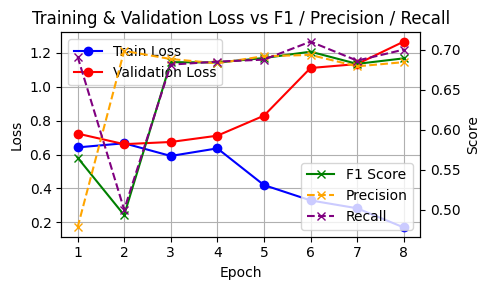

In [23]:
import matplotlib.pyplot as plt
import pandas as pd

log_history = trainer.state.log_history

# Separate training and evaluation entries
eval_logs = [log for log in log_history if "eval_loss" in log]
train_logs = [log for log in log_history if "loss" in log and "epoch" in log]

# Convert to DataFrames
df_eval = pd.DataFrame(eval_logs)
df_train = pd.DataFrame(train_logs)

# Merge by epoch
df = pd.merge(df_eval, df_train[["epoch", "loss"]], on="epoch", how="left")

# Plotting
fig, ax1 = plt.subplots(figsize=(5, 3))

# Plot training and validation loss
ax1.plot(df['epoch'], df['loss'], label='Train Loss', color='blue', marker='o')
ax1.plot(df['epoch'], df['eval_loss'], label='Validation Loss', color='red', marker='o')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper left')
ax1.grid(True)

# Plot F1, Precision, Recall on secondary axis
ax2 = ax1.twinx()
ax2.plot(df['epoch'], df['eval_f1'], label='F1 Score', color='green', marker='x')
ax2.plot(df['epoch'], df['eval_precision'], label='Precision', color='orange', linestyle='--', marker='x')
ax2.plot(df['epoch'], df['eval_recall'], label='Recall', color='purple', linestyle='--', marker='x')
ax2.set_ylabel('Score')
ax2.legend(loc='lower right')

plt.title('Training & Validation Loss vs F1 / Precision / Recall')
plt.tight_layout()
plt.show()


In [24]:
import pandas as pd
import numpy as np

# Get predictions
predictions = trainer.predict(tokenized["test"])
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

# Decode input_ids from the tokenized test set
decoded_texts = tokenizer.batch_decode(tokenized["test"]["input_ids"], skip_special_tokens=True)

# Create DataFrame with predictions and text
results_df = pd.DataFrame({
    "text": decoded_texts,
    "true_label": y_true,
    "predicted_label": y_pred
})

# Identify true positives, false negatives, false positives
TP = results_df[(results_df.true_label == 1) & (results_df.predicted_label == 1)].sample(n=2)
FN = results_df[(results_df.true_label == 1) & (results_df.predicted_label == 0)].sample(n=2)
FP = results_df[(results_df.true_label == 0) & (results_df.predicted_label == 1)].sample(n=2)
TN = results_df[(results_df.true_label == 0) & (results_df.predicted_label == 0)].sample(n=2)


# Function to format text into LaTeX paragraphs with correct chronological order
def format_latex_paragraphs(df):
    formatted_text = ""
    for _, row in df.iterrows():
        dialogue = row['text'].split("\n")

        # Ensure chronological order
        person1_dialogue = [line for line in dialogue if line.startswith("Person1")]
        person2_dialogue = [line for line in dialogue if line.startswith("Person2")]

        # Interleave dialogues between Person1 and Person2 in chronological order
        dialogue_ordered = []
        person1_idx, person2_idx = 0, 0
        while person1_idx < len(person1_dialogue) or person2_idx < len(person2_dialogue):
            if person1_idx < len(person1_dialogue):
                dialogue_ordered.append("\\noindent\\textbf{Person1:} " + person1_dialogue[person1_idx][8:] + " \\\\")
                person1_idx += 1
            if person2_idx < len(person2_dialogue):
                dialogue_ordered.append("\\noindent\\textbf{Person2:} " + person2_dialogue[person2_idx][8:] + " \\\\")
                person2_idx += 1

        formatted_text += " \n".join(dialogue_ordered) + "\n\n"
    return formatted_text

# Print examples as LaTeX paragraphs in chronological order

print("\n\\subsection{True Positives:}")
print("{\\ttfamily \\tiny")
print(format_latex_paragraphs(TP))
print("}")

print("\n\\subsection{False Negatives:}")
print("{\\ttfamily \\tiny")
print(format_latex_paragraphs(FN))
print("}")

print("\n\\subsection{False Positives:}")
print("{\\ttfamily \\tiny")
print(format_latex_paragraphs(FP))
print("}")

print("\n\\subsection{True Negatives:}")
print("{\\ttfamily \\tiny")
print(format_latex_paragraphs(TN))
print("}")







/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



\subsection{True Positives:}
{\ttfamily \tiny
\noindent\textbf{Person1:}  Don't you think you're overreacting just a little here?   We're talking about love, okay?  Let's be rational. \\ 
\noindent\textbf{Person2:}  Rational?!  Love is not rational! Are you crazy? \\ 
\noindent\textbf{Person1:}  Yes.  I'm crazy.  You have driven me crazy.  No one in their right mind would go to this much trouble to win over someone as insane as you.  Did it ever, even for one second, occur to you how much work it was to set all this up?  How many arrangements had to be made? How many players had \\

\noindent\textbf{Person1:}  You know it amazes me that someone as bright as you can be so horrible. \\ 
\noindent\textbf{Person2:}  What? Another letter from your friend? \\ 
\noindent\textbf{Person1:}  This is my favorite part.  Even more treacherous and dangerous than he is charming and fascinating. He has never taken a single step or spoken a single word without some dishonorable or criminal intention. 

In [25]:
""

''